In [2]:
import joblib

xgb_loaded = joblib.load("models/xgb_calibrated.pkl")
raw_xgb = xgb_loaded.estimator
print("Using model:", type(raw_xgb))

Using model: <class 'xgboost.sklearn.XGBClassifier'>


/Users/vimu/Documents/Data Science/00 Thesis/Github/aml-mule-risk-scoring/venv/lib/python3.13/site-packages/xgboost/core.py:160: UserWarning: [11:08:49] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [21]:
import os

os.makedirs("figures", exist_ok=True)

In [4]:
import pandas as pd

features = pd.read_csv("data/features_account_level.csv")
feature_cols = [c for c in features.columns if c not in ("is_mule","account_id")]

X = features[feature_cols]
print("Feature shape:", X.shape)

Feature shape: (5000, 16)


In [9]:
feature_names = X.columns.tolist()
print("Feature names loaded:", len(feature_names))

Feature names loaded: 16


In [5]:
import shap
import numpy as np

# Safety patches for deprecated numpy types used inside SHAP
if not hasattr(np, "int"): np.int = int
if not hasattr(np, "bool"): np.bool = bool   # <-- ADD THIS

explainer = shap.Explainer(raw_xgb, X)
shap_values = explainer(X)
print("✓ SHAP computed:", type(shap_values))

[11:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 4982/5000 [00:22<00:00]        

✓ SHAP computed: <class 'shap._explanation.Explanation'>


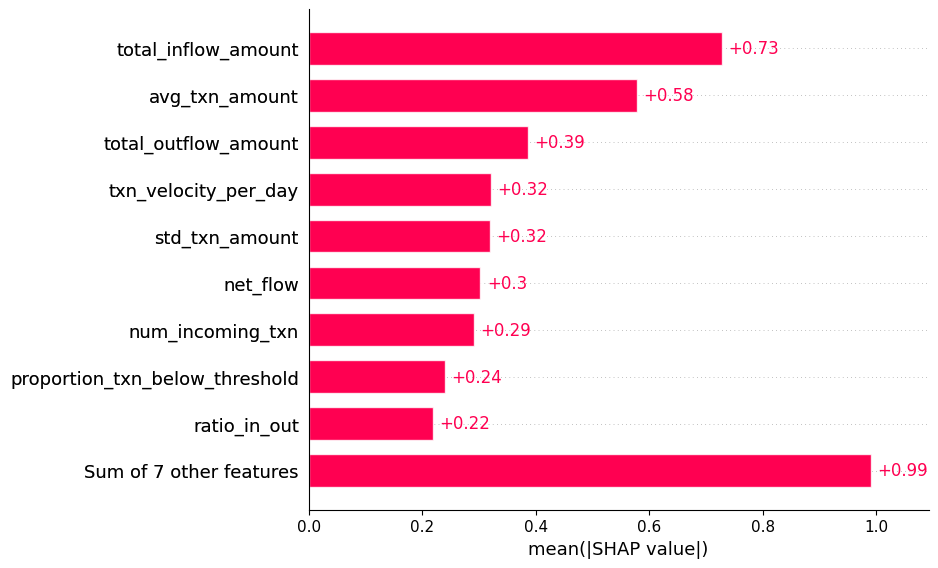

In [6]:
import shap
shap.plots.bar(shap_values, max_display=10)

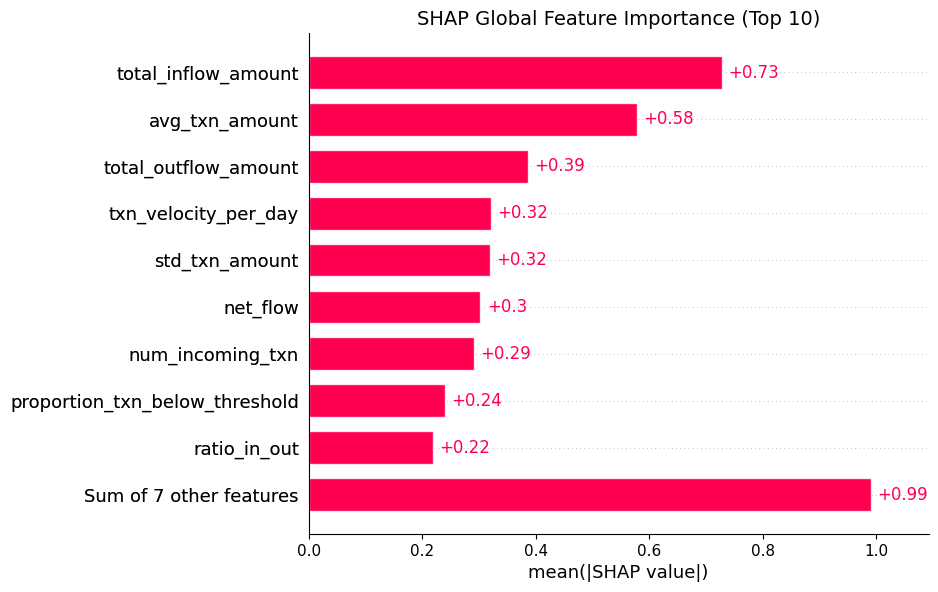

In [35]:
import os
import matplotlib.pyplot as plt
import shap

# Ensure fresh canvas
plt.close("all")

# --- Create figure BEFORE SHAP draws ---
fig = plt.figure(figsize=(10, 6))

# --- Draw bar plot ---
shap.plots.bar(
    shap_values,
    max_display=10,
    show=False        # <-- important for saving
)

# --- Title (optional) ---
plt.title("SHAP Global Feature Importance (Top 10)", fontsize=14)

# --- Save to /figures ---
os.makedirs("figures", exist_ok=True)

fig.savefig(
    "figures/shap_bar_top10.png",
    dpi=300,
    bbox_inches="tight"
)

# --- Show on screen ---
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.close('all')
shap.plots.beeswarm(shap_values, max_display=10, color_bar=False)
plt.gcf().set_size_inches(12, 8)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


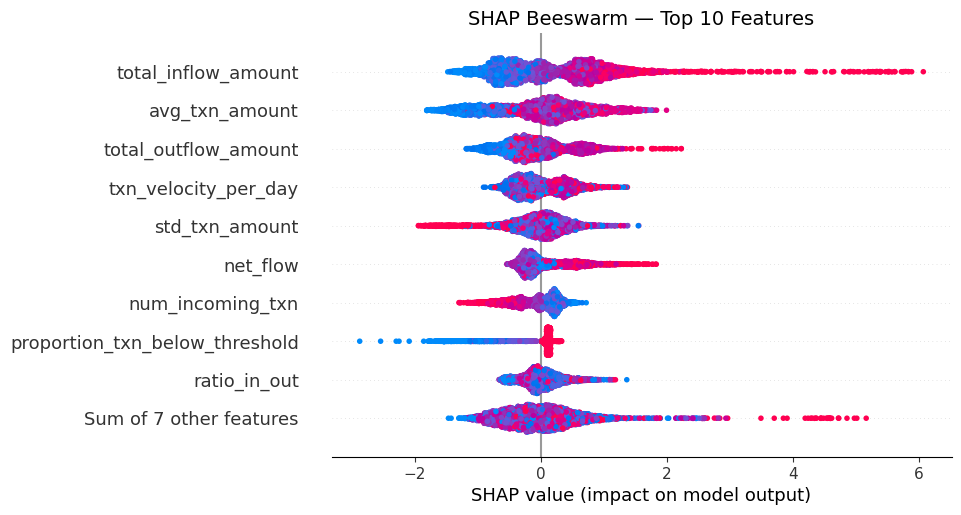

In [34]:
import os
import matplotlib.pyplot as plt
import shap

# Ensure clean state
plt.close("all")

# --- Create figure *before* SHAP draws ---
fig = plt.figure(figsize=(12, 8))

# --- Draw Beeswarm ---
shap.plots.beeswarm(
    shap_values,
    max_display=10,
    color_bar=False,
    show=False          # <-- KEY for saving
)

# --- Title (optional) ---
plt.title("SHAP Beeswarm — Top 10 Features", fontsize=14)

# --- Save (uses the correct figure object) ---
os.makedirs("figures", exist_ok=True)
fig.savefig(
    "figures/shap_beeswarm_top10.png",
    dpi=300,
    bbox_inches="tight"
)

# --- Show ---
plt.show()

In [10]:
raw_xgb        # underlying XGBoost model
X              # feature matrix (test or full)
shap_values    # SHAP explanation object
feature_names  # list of feature names (optional)

['total_inflow_amount',
 'total_outflow_amount',
 'log_total_inflow',
 'log_total_outflow',
 'num_unique_senders',
 'num_unique_receivers',
 'num_incoming_txn',
 'num_outgoing_txn',
 'txn_velocity_per_day',
 'num_txn_below_threshold',
 'proportion_txn_below_threshold',
 'avg_txn_amount',
 'std_txn_amount',
 'zscore_outflow',
 'net_flow',
 'ratio_in_out']

In [12]:
import numpy as np

probs = raw_xgb.predict_proba(X)[:, 1]
idx = np.argmax(probs)

print("Selected index:", idx)
print("Predicted probability:", probs[idx])

Selected index: 4441
Predicted probability: 0.9994105


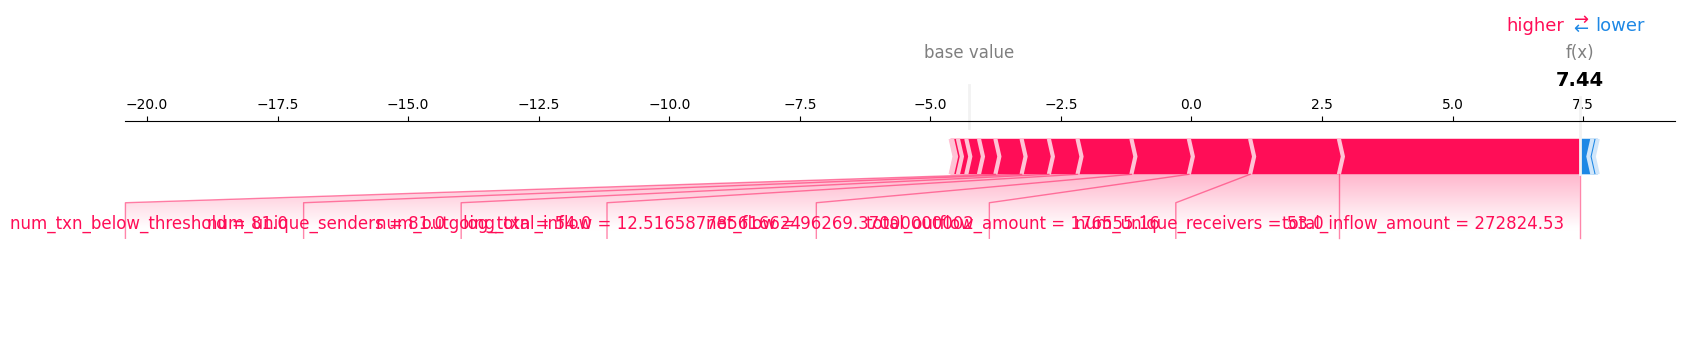

In [13]:
import shap

# force plot for single sample
shap.plots.force(
    shap_values[idx],
    X.iloc[idx],
    feature_names=feature_names,
    matplotlib=True
)

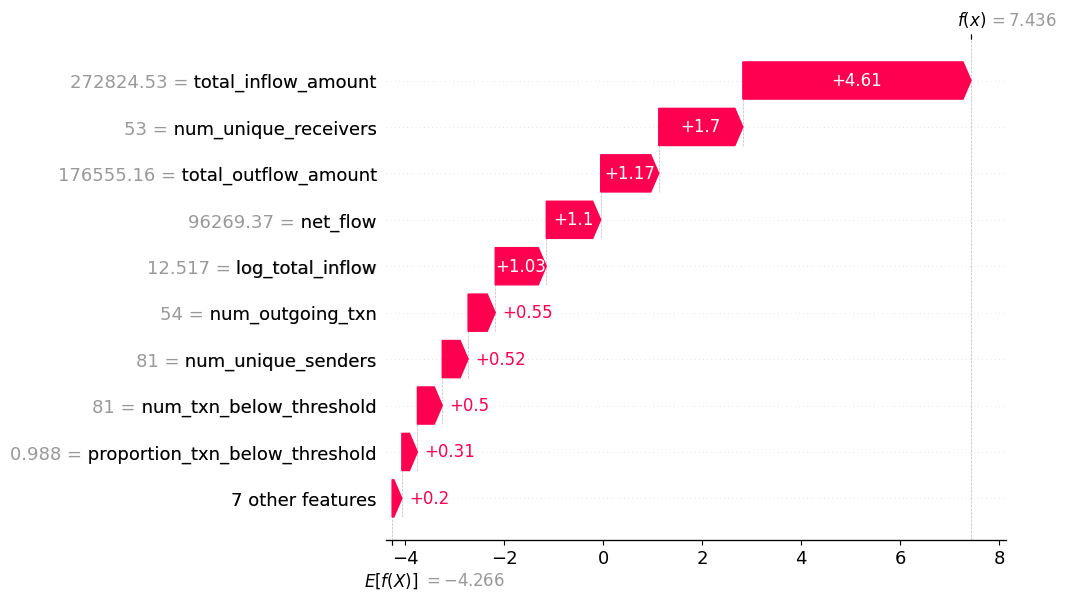

In [15]:
idx = np.argmax(probs)

shap.plots.waterfall(
    shap_values[idx],
    max_display=10,
    show=True
)

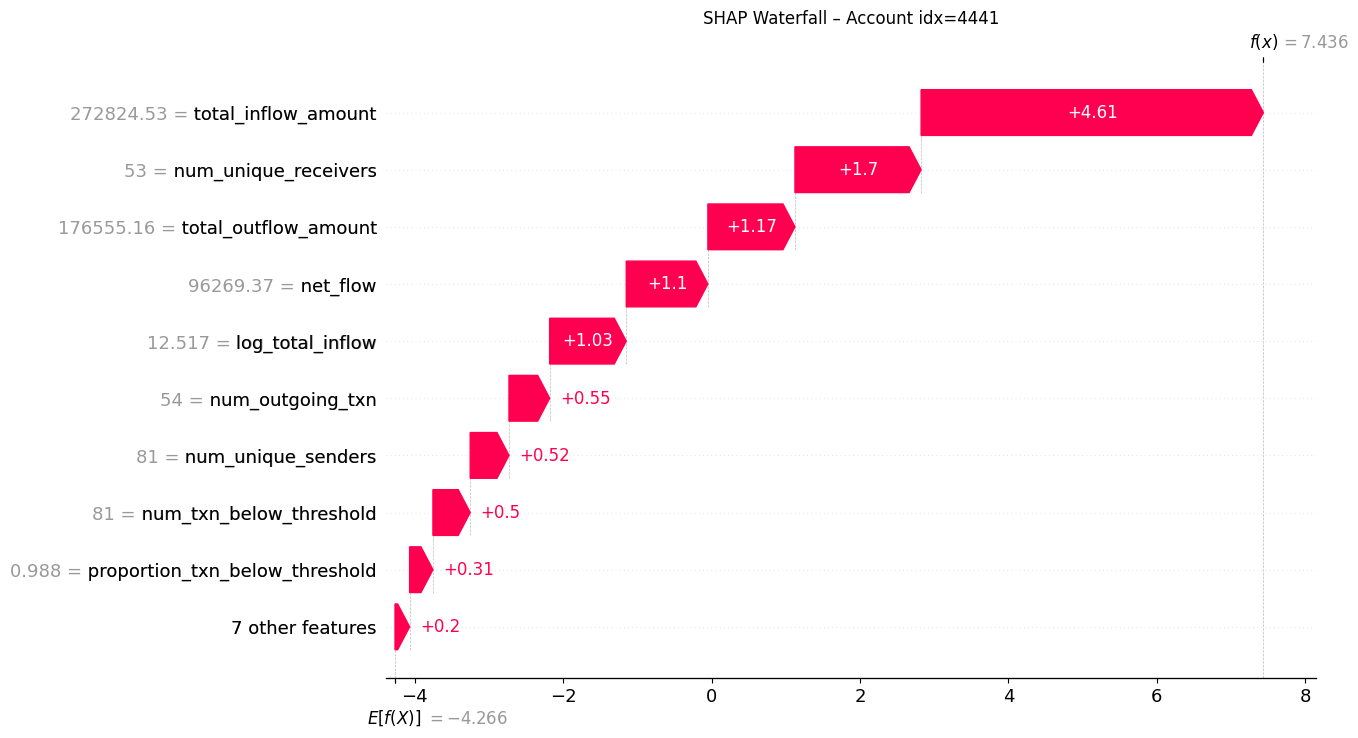

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap

# --------------------------------
# 1) Pick example (highest risk)
# --------------------------------
idx = np.argmax(probs)

# --------------------------------
# 2) Create SHAP waterfall plot
#    (NO ax, NO show=True)
# --------------------------------
plt.close('all')
shap.plots.waterfall(
    shap_values[idx],
    max_display=10,
    show=False         # IMPORTANT
)

# --------------------------------
# 3) Add title AFTER plot generation
# --------------------------------
plt.title(f"SHAP Waterfall – Account idx={idx}")

# --------------------------------
# 4) Save figure using current figure
# --------------------------------
os.makedirs("figures", exist_ok=True)
plt.gcf().set_size_inches(12, 8)

plt.savefig(
    "figures/shap_waterfall_toprisk.png",
    dpi=300,
    bbox_inches="tight"
)

# --------------------------------
# 5) Display
# --------------------------------
plt.show()

In [22]:
import shap
import numpy as np

# Safety patches for deprecated numpy types used inside SHAP
if not hasattr(np, "int"): np.int = int
if not hasattr(np, "bool"): np.bool = bool
if not hasattr(np, "float"): np.float = float   # <--- NEW

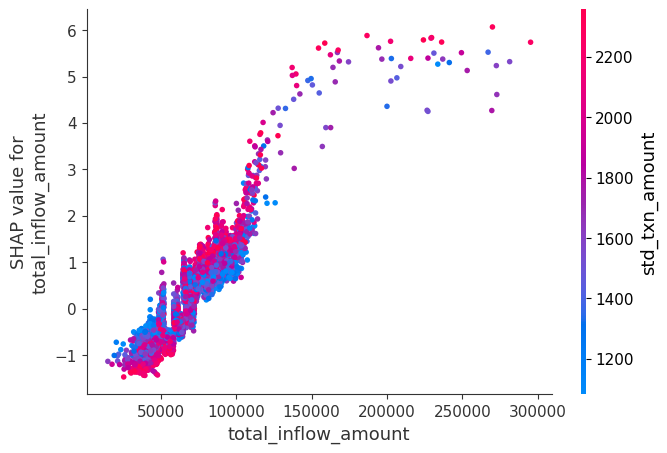

In [23]:
shap.dependence_plot(
    "total_inflow_amount",
    shap_values.values,
    X,
    show=False
)

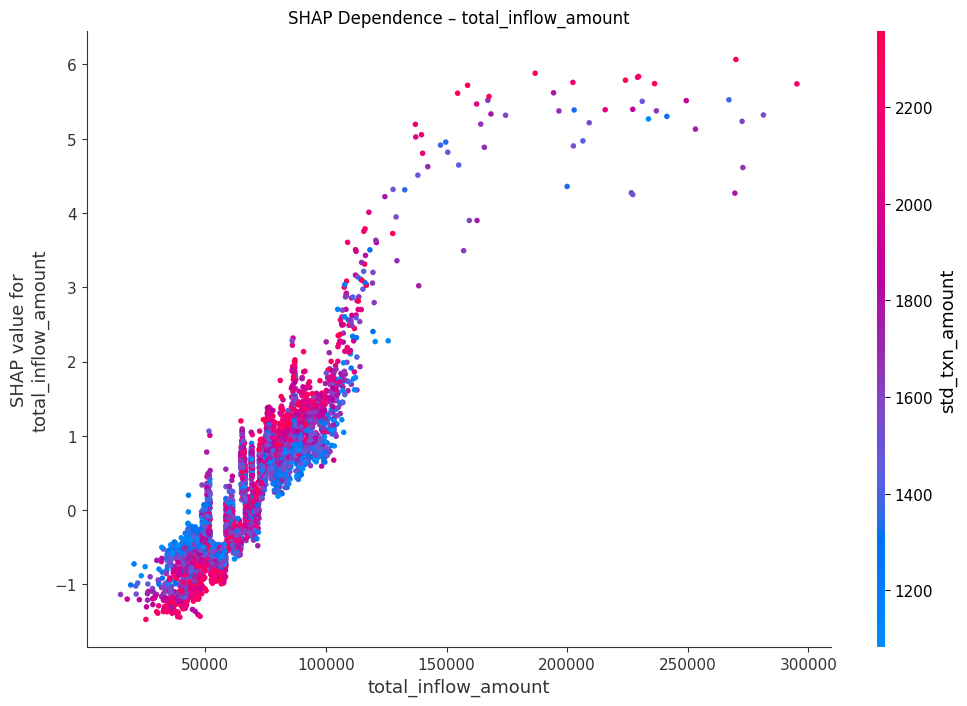

In [25]:
import matplotlib.pyplot as plt
import shap
import os

os.makedirs("figures", exist_ok=True)

fig = plt.figure()   # create figure
shap.dependence_plot(
    "total_inflow_amount",
    shap_values.values,
    X,
    ax=plt.gca(),     # attach SHAP plot to current axes
    show=False
)

plt.title("SHAP Dependence – total_inflow_amount")
plt.gcf().set_size_inches(12, 8)
plt.savefig("figures/shap_dependence_inflow.png", dpi=300, bbox_inches="tight")
plt.show()

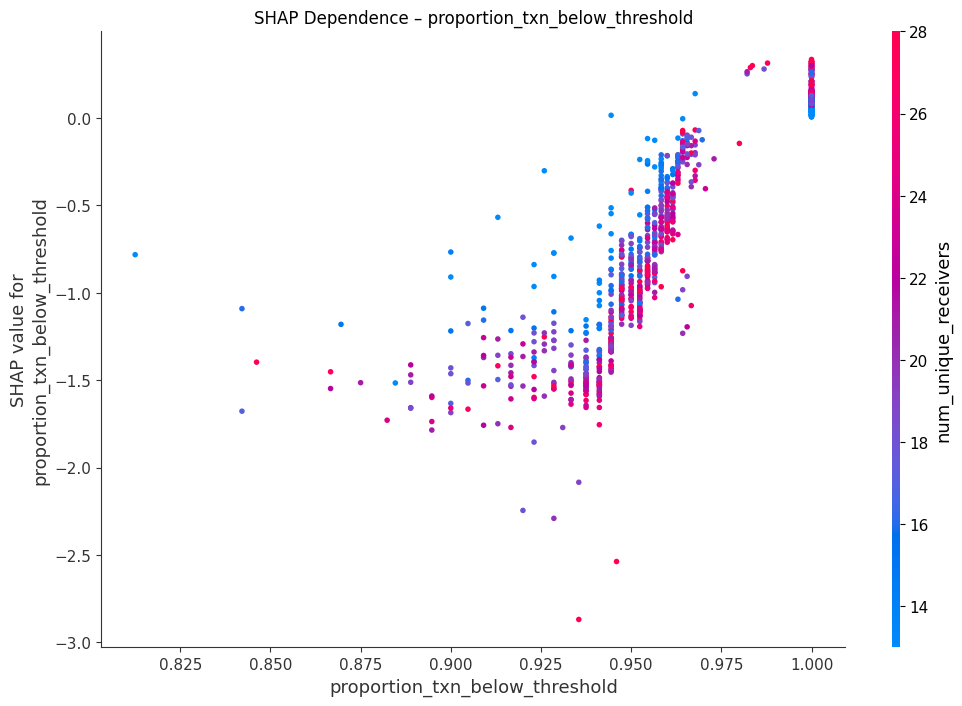

In [26]:
import os
import shap
import matplotlib.pyplot as plt

# Ensure output folder exists
os.makedirs("figures", exist_ok=True)

# Close old figures
plt.close('all')

# Create figure + axis
fig, ax = plt.subplots(figsize=(12, 8))

# Draw dependence plot on our axis
shap.dependence_plot(
    "proportion_txn_below_threshold",
    shap_values.values,
    X,
    ax=ax,              # IMPORTANT: attach to this axis
    show=False
)

# Add title and save
ax.set_title("SHAP Dependence – proportion_txn_below_threshold")
fig.savefig("figures/shap_dependence_proportion.png", dpi=300, bbox_inches="tight")

plt.show()

In [37]:
import os

os.makedirs("outputs", exist_ok=True)

In [43]:
import os

os.makedirs("reports/accounts", exist_ok=True)

In [38]:
import pandas as pd
import numpy as np

shap_mean = np.abs(shap_values.values).mean(axis=0)
df = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": shap_mean
})
df["rank"] = df["mean_abs_shap"].rank(ascending=False)

df.sort_values("rank").to_csv("outputs/shap_global_feature_importance.csv", index=False)
print("✓ Exported global SHAP CSV")

✓ Exported global SHAP CSV


In [39]:
def explain_account(idx):
    vals = shap_values[idx]
    row = X.iloc[idx]

    waterfall_path = f"reports/accounts/account_{idx}_waterfall.png"
    
    shap.plots.waterfall(
        vals,
        max_display=10,
        show=False
    )
    plt.savefig(waterfall_path, dpi=300, bbox_inches="tight")
    plt.close()

    print("✓ Saved:", waterfall_path)
    return waterfall_path

In [40]:
def narrate(idx):
    vals = shap_values[idx]
    row = X.iloc[idx]

    top = np.abs(vals.values).argsort()[::-1][:5]
    
    lines = []
    for t in top:
        f = feature_cols[t]
        v = row[f]
        c = vals.values[t]
        lines.append(f"- {f} = {v:.2f}, contributes {c:+.2f}")

    explanation = "\n".join(lines)

    text_path = f"outputs/account_{idx}_explanation.txt"
    with open(text_path, "w") as f:
        f.write(explanation)

    print("✓ Saved:", text_path)

In [41]:
def explain_account_full(idx):
    explain_account(idx)
    narrate(idx)

In [44]:
explain_account_full(4441)

✓ Saved: reports/accounts/account_4441_waterfall.png
✓ Saved: outputs/account_4441_explanation.txt
